In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib.pylab as plt
# %matplotlib inline

# 支持中文
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 用来正常显示中文标签
# plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
plt.rcParams['font.sans-serif'] = ['SimHei'] #设置画图的中文字体显示
plt.rcParams['axes.unicode_minus'] = False   #显示负号
plt.rcParams['font.size'] = 22

#隐藏红色警示框
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

seed = 123

In [2]:
original_huayan_df = pd.read_excel('huayan_data.xlsx')
original_plc_df = pd.read_excel('plc_data2.xlsx')
test_df = pd.read_excel('test_data.xlsx')
original_plc_df.columns

Index(['时间', '给料皮带G1_矿量反馈', '返料皮带F3_电流', '返料皮带F3_矿量', '半自磨_功率1', '半自磨_功率2',
       '半自磨_进料端总高压', '半自磨_出料端总高压', '半自磨_给矿水流量反馈', '半自磨_给矿水流量设定', '半自磨_给矿水阀位',
       '半自磨_排矿水流量', '直线筛_冲筛水流量', '一段泵池_液位', '一段泵池_补加水流量反馈', '一段渣浆泵1_电流',
       '一段渣浆泵1_频率反馈', '一段渣浆泵1_频率设定', '一段渣浆泵1_矿浆流量反馈', '一段渣浆泵1_矿浆流量设定',
       '一段渣浆泵2_电流', '一段渣浆泵2_频率反馈', '一段渣浆泵2_频率设定', '一段渣浆泵2_立管补水流量',
       '一段渣浆泵2_矿浆流量反馈', '一段渣浆泵2_矿浆流量设定', '一段旋流器1_压力', '一段旋流器2_压力', '球磨机_功率1',
       '球磨机_功率2', '球磨机_进料端总高压', '球磨机_出料端总高压', '球磨机_排矿水流量', '球磨机_排矿水阀位'],
      dtype='object')

# 时间平移及相关性分析

In [3]:
# outcome_col = '1系列原矿处理量t/h'
# outcome_col = '1系列返矿量t/h'
# outcome_col = '1系列1段旋流器A组溢流浓度/%'
# outcome_col = '1系列强磁尾矿品位TFe/%'
outcome_col = '1系列1段旋流器A组溢流粒度/-200目'

# target_cols = ['半自磨_功率1', '半自磨_功率2', '球磨机_功率1', '球磨机_功率2']
target_cols = ['给料皮带G1_矿量反馈', '返料皮带F3_电流', '半自磨_进料端总高压', '一段泵池_液位', '一段渣浆泵1_矿浆流量反馈', '一段旋流器1_压力', '球磨机_出料端总高压']
shifting_labels = ['平均值时间范围（分钟）', '时间戳移动量（分钟）']

huayan_df = original_huayan_df[['时间'] + [outcome_col]].copy()

all_shifted_df = []
for group_time_min in (0.5, 1, 5, 10, 20, 30, 60):
    for shifted_time_min in (0, 1, 5, 10, 15, 30, 60, 90, 120, 150, 180):
        if (group_time_min / 2) > shifted_time_min:
            continue
        plc_df = original_plc_df[['时间'] + target_cols].copy()

        plc_df.loc[:, '时间'] = plc_df.loc[:, '时间'] - timedelta(minutes=shifted_time_min)
        plc_df.loc[:, '时间'] = plc_df.loc[:, '时间'].dt.round(f'{group_time_min}min')

        plc_df = plc_df.groupby("时间").mean().reset_index()

        shifted_corr_single_df = huayan_df.merge(plc_df, how="left", on="时间").dropna().corr().loc[[outcome_col], target_cols].abs().round(2)
        shifted_corr_single_df[shifting_labels] = (group_time_min, shifted_time_min)
        
        all_shifted_df.append(shifted_corr_single_df)
all_shifted_df = pd.concat(all_shifted_df).reset_index(drop=True)

对于给料皮带G1_矿量反馈, 使用150分钟之前，前后共5分钟数据的平均值 (相关系数绝对值: 0.150)


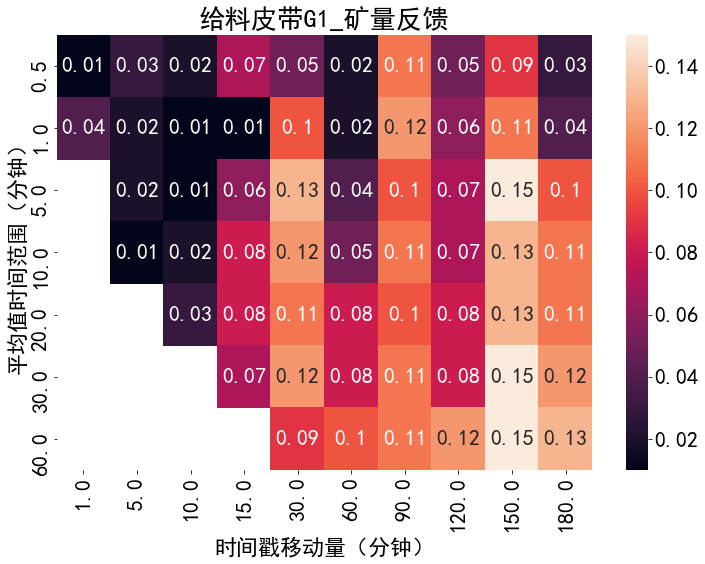





对于返料皮带F3_电流, 使用150分钟之前，前后共0.5分钟数据的平均值 (相关系数绝对值: 0.090)


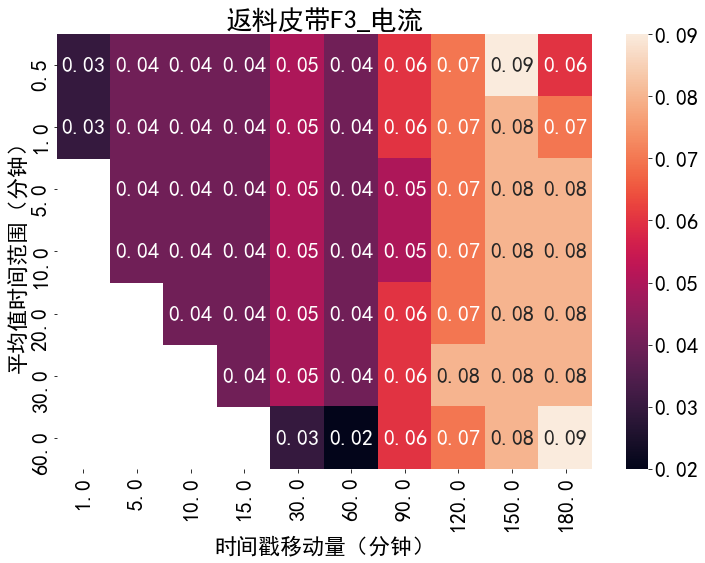





对于半自磨_进料端总高压, 使用120分钟之前，前后共0.5分钟数据的平均值 (相关系数绝对值: 0.100)


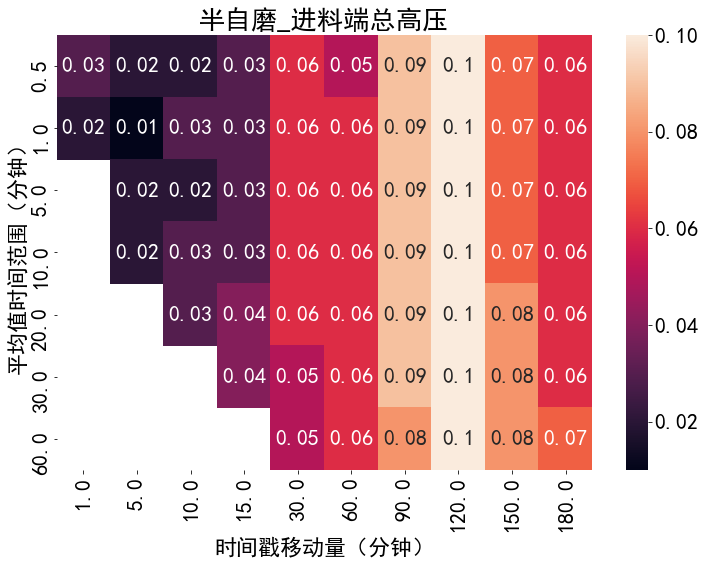





对于一段泵池_液位, 使用60分钟之前，前后共0.5分钟数据的平均值 (相关系数绝对值: 0.060)


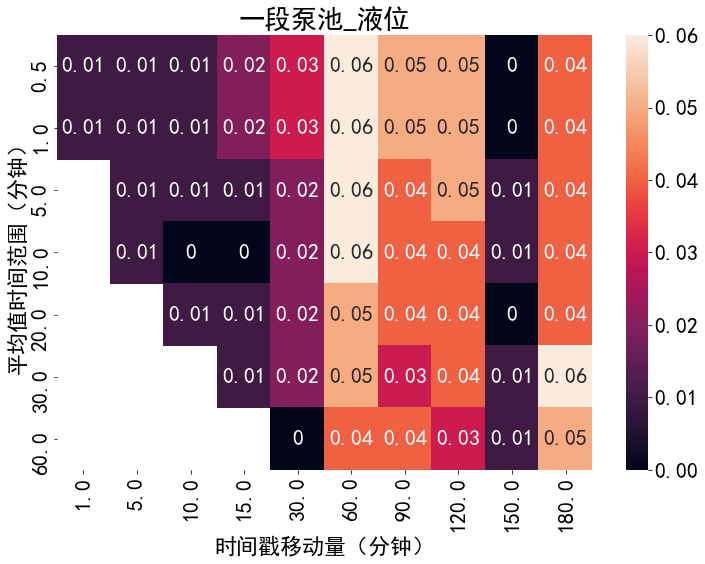





对于一段渣浆泵1_矿浆流量反馈, 使用1分钟之前，前后共0.5分钟数据的平均值 (相关系数绝对值: 0.160)


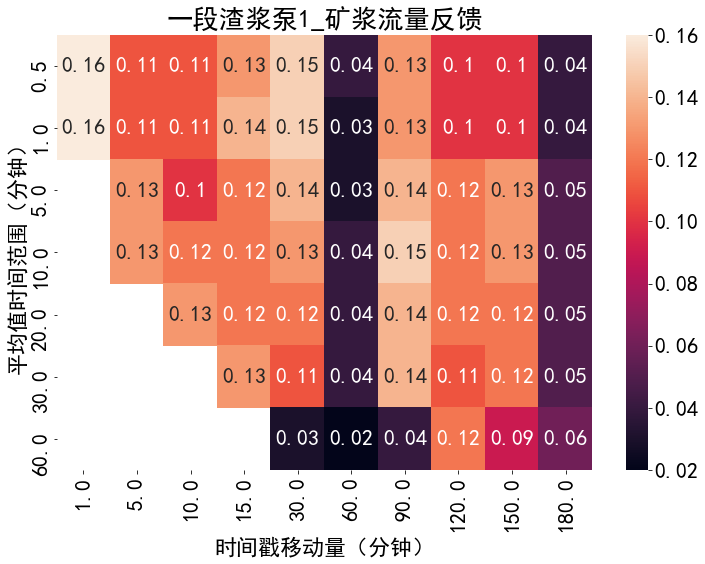





对于一段旋流器1_压力, 使用150分钟之前，前后共0.5分钟数据的平均值 (相关系数绝对值: 0.140)


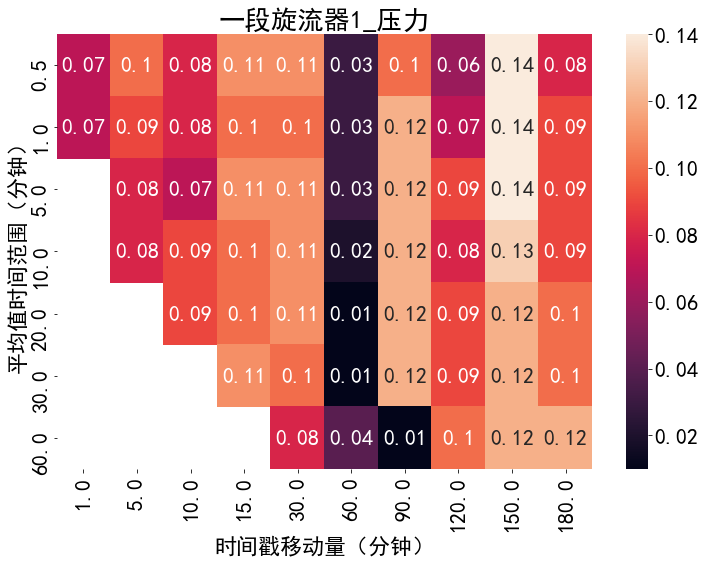





对于球磨机_出料端总高压, 使用10分钟之前，前后共5分钟数据的平均值 (相关系数绝对值: 0.070)


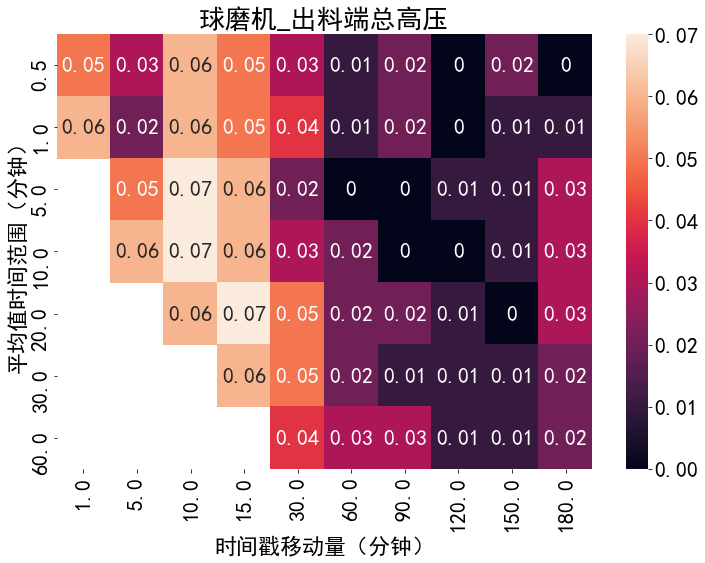

In [4]:
for corr_col in target_cols:
    plt.figure(figsize=(12, 8))
    pivoted_hm_df = pd.pivot_table(all_shifted_df, values=corr_col, index=shifting_labels[0], columns=shifting_labels[1])
    sns.heatmap(pivoted_hm_df, annot=True)
    plt.title(corr_col)
    
    group_time_min, shifted_time_min, corr_val = all_shifted_df.loc[all_shifted_df[corr_col].idxmax(), shifting_labels + [corr_col]]
    print(f"对于{corr_col}, 使用{shifted_time_min:g}分钟之前，前后共{group_time_min:g}分钟数据的平均值 (相关系数绝对值: {corr_val:.3f})")
    plt.show()
    print("\n"*3)

In [5]:
huayan_df = huayan_df.dropna()

df0 = original_plc_df[['时间','给料皮带G1_矿量反馈']]
df1 = original_plc_df[['时间','返料皮带F3_电流', '返料皮带F3_矿量']]
df2 = original_plc_df[['时间','半自磨_功率1', '半自磨_功率2','半自磨_进料端总高压', '半自磨_出料端总高压', '半自磨_给矿水流量反馈', 
                       '半自磨_给矿水流量设定', '半自磨_给矿水阀位','半自磨_排矿水流量', '直线筛_冲筛水流量']]
df3 = original_plc_df[['时间','一段泵池_液位', '一段泵池_补加水流量反馈']]
df4 = original_plc_df[['时间','一段渣浆泵1_电流','一段渣浆泵1_频率反馈', '一段渣浆泵1_频率设定', '一段渣浆泵1_矿浆流量反馈', '一段渣浆泵1_矿浆流量设定']]
df5 = original_plc_df[['时间','一段旋流器1_压力']]
df6 = original_plc_df[['时间','球磨机_功率1','球磨机_功率2', '球磨机_进料端总高压', '球磨机_出料端总高压', '球磨机_排矿水流量', '球磨机_排矿水阀位']]

In [6]:
df_set = [df0,df1,df2,df3,df4,df5,df6]
shift = [150,150,120,60,1,150,10]
freq = ['5min','0.5min','0.5min','0.5min','0.5min','0.5min','5min']
for i in range(7):
    df_set[i].loc[:, '时间'] = df_set[i].loc[:, '时间'] - timedelta(minutes=shift[i])
    df_set[i].loc[:, '时间'] = df_set[i].loc[:, '时间'].dt.round(freq[i])
    df_set[i] = df_set[i].groupby("时间").mean().reset_index()
    df_set[i] = huayan_df.merge(df_set[i], how="left", on="时间").dropna(axis = 0,how = 'any')
    df_set[i].reset_index(inplace=True,drop=True)

In [7]:
from functools import reduce

df_list = [df_set[1],df_set[2],df_set[3],df_set[4],df_set[5],df_set[6]]
df_list = [df_set[0],df_set[1],df_set[2],df_set[3],df_set[4],df_set[5],df_set[6]]
new_df = reduce(lambda left, right: pd.merge(left, right, on=['时间','1系列1段旋流器A组溢流粒度/-200目']), df_list)
new_df

,时间,1系列1段旋流器A组溢流粒度/-200目,给料皮带G1_矿量反馈,返料皮带F3_电流,返料皮带F3_矿量,半自磨_功率1,半自磨_功率2,半自磨_进料端总高压,半自磨_出料端总高压,半自磨_给矿水流量反馈,...,一段渣浆泵1_频率设定,一段渣浆泵1_矿浆流量反馈,一段渣浆泵1_矿浆流量设定,一段旋流器1_压力,球磨机_功率1,球磨机_功率2,球磨机_进料端总高压,球磨机_出料端总高压,球磨机_排矿水流量,球磨机_排矿水阀位
0,2022-02-26 17:00:00,88.63,960.185726,27.489000,44.192995,3359.80,3402.00,742.80,871.00,208.796271,...,80.334660,2937.933838,80.334660,0.068576,4510.666667,4504.857143,63.142857,57.285714,8.628885,99.421295
1,2022-02-26 21:00:00,89.13,988.423419,25.713600,68.709021,3351.00,3319.75,743.00,872.50,207.870361,...,79.940670,2963.150879,79.940670,0.069444,4540.204545,4533.227273,63.454545,57.863636,8.384627,99.305557
2,2022-02-26 23:00:00,88.86,958.574751,25.657500,70.039062,3651.00,3644.25,752.25,883.50,210.069443,...,80.148487,2948.263672,80.148487,0.068685,4543.909091,4545.431818,63.545455,58.000000,8.450389,99.272666
3,2022-02-27 01:00:00,89.41,957.727908,25.805999,56.710415,3454.25,3456.75,749.25,881.00,208.043968,...,80.043207,2948.749902,80.043207,0.070070,4550.452381,4543.238095,63.952381,58.000000,8.542768,99.218750
4,2022-02-27 03:00:00,88.50,952.964540,25.838999,57.634836,3444.80,3481.40,748.40,883.00,206.435168,...,79.979939,2956.466919,79.979939,0.071918,4520.023256,4530.488372,63.023256,58.000000,8.461859,99.147417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2022-03-17 01:00:00,89.83,964.794618,26.017199,111.949301,3414.25,3453.25,734.00,886.25,222.337967,...,80.911804,3010.850586,80.911804,0.073420,4735.285714,4734.595238,64.000000,58.000000,8.422205,99.710648
212,2022-03-17 03:00:00,88.24,959.950018,26.043599,127.494672,3353.50,3374.25,734.50,885.50,218.460640,...,81.154514,2981.683838,81.154514,0.074063,4732.375000,4720.250000,64.000000,58.000000,8.210358,99.652771
213,2022-03-17 05:00:00,89.70,957.355026,26.505601,105.949997,3261.80,3271.80,733.80,885.40,220.370361,...,81.000519,2986.423633,81.000519,0.071719,4717.975000,4712.575000,64.000000,58.075000,8.192274,99.565964
214,2022-03-17 07:00:00,88.18,962.405721,27.456000,106.968746,3278.80,3245.80,736.80,886.60,221.851855,...,80.963260,2993.836670,80.963260,0.049653,4705.878049,4712.560976,64.000000,58.634146,8.274757,99.462930


In [8]:
new_df.corr()['1系列1段旋流器A组溢流粒度/-200目'].sort_values(ascending=False)

1系列1段旋流器A组溢流粒度/-200目    1.000000
球磨机_功率1                 0.174716
球磨机_功率2                 0.174042
一段渣浆泵1_矿浆流量反馈           0.168372
球磨机_排矿水阀位               0.148740
一段旋流器1_压力               0.148018
一段泵池_补加水流量反馈            0.147893
返料皮带F3_矿量               0.083974
球磨机_出料端总高压              0.083332
半自磨_功率1                 0.058267
一段渣浆泵1_频率反馈             0.051957
一段渣浆泵1_矿浆流量设定           0.049239
一段渣浆泵1_频率设定             0.049239
半自磨_排矿水流量               0.043478
半自磨_功率2                 0.042815
一段泵池_液位                 0.038029
球磨机_进料端总高压              0.024943
直线筛_冲筛水流量               0.022448
半自磨_给矿水流量设定             0.003677
半自磨_给矿水阀位               0.002774
球磨机_排矿水流量              -0.014656
半自磨_给矿水流量反馈            -0.020514
半自磨_出料端总高压             -0.051419
一段渣浆泵1_电流              -0.072575
返料皮带F3_电流              -0.083055
半自磨_进料端总高压             -0.091792
给料皮带G1_矿量反馈            -0.146272
Name: 1系列1段旋流器A组溢流粒度/-200目, dtype: float64

## 划分数据集及标准化

In [9]:
from sklearn.preprocessing import StandardScaler

target = new_df['1系列1段旋流器A组溢流粒度/-200目']
regressors = [x for x in new_df.columns if x not in ['时间','1系列1段旋流器A组溢流粒度/-200目']]
features = new_df[regressors] 
features=StandardScaler().fit_transform(features) #进行标准化处理
features = pd.DataFrame(features)
c = ['给料皮带G1_矿量反馈','返料皮带F3_电流', '返料皮带F3_矿量','半自磨_功率1', '半自磨_功率2','半自磨_进料端总高压', '半自磨_出料端总高压',
        '半自磨_给矿水流量反馈', '半自磨_给矿水流量设定', '半自磨_给矿水阀位','半自磨_排矿水流量', '直线筛_冲筛水流量','一段泵池_液位', '一段泵池_补加水流量反馈',
        '一段渣浆泵1_电流','一段渣浆泵1_频率反馈', '一段渣浆泵1_频率设定', '一段渣浆泵1_矿浆流量反馈', '一段渣浆泵1_矿浆流量设定','一段旋流器1_压力','球磨机_功率1',
        '球磨机_功率2', '球磨机_进料端总高压', '球磨机_出料端总高压', '球磨机_排矿水流量', '球磨机_排矿水阀位']
features.columns = c
features.head()

,给料皮带G1_矿量反馈,返料皮带F3_电流,返料皮带F3_矿量,半自磨_功率1,半自磨_功率2,半自磨_进料端总高压,半自磨_出料端总高压,半自磨_给矿水流量反馈,半自磨_给矿水流量设定,半自磨_给矿水阀位,...,一段渣浆泵1_频率设定,一段渣浆泵1_矿浆流量反馈,一段渣浆泵1_矿浆流量设定,一段旋流器1_压力,球磨机_功率1,球磨机_功率2,球磨机_进料端总高压,球磨机_出料端总高压,球磨机_排矿水流量,球磨机_排矿水阀位
0,0.182710,0.962884,-1.934569,-0.303396,-0.130173,0.817250,-0.162390,-0.873567,-0.544547,-0.515101,...,-1.026704,-1.051353,-1.026704,-0.447477,-1.273388,-1.356028,-1.575673,-0.965138,-0.535710,-0.791339
1,2.036801,-1.453118,-1.225606,-0.342962,-0.504093,0.835286,-0.028953,-0.922969,-0.583838,-0.788344,...,-1.988661,-0.527747,-1.988661,-0.207726,-0.821898,-0.921998,-0.718338,0.358193,-1.457063,-1.183853
2,0.076933,-1.529459,-1.187144,1.005869,0.971128,1.669430,0.949586,-0.805637,-0.628121,-0.705820,...,-1.481259,-0.836865,-1.481259,-0.417437,-0.765274,-0.735283,-0.468283,0.670439,-1.209006,-1.295400
3,0.021330,-1.327379,-1.572586,0.121261,0.118727,1.398897,0.727191,-0.913706,-0.685183,-0.657682,...,-1.738310,-0.826768,-1.738310,-0.034973,-0.665259,-0.768844,0.651014,0.670439,-0.860545,-1.478251
4,-0.291434,-1.282472,-1.545853,0.078772,0.230790,1.322246,0.905107,-0.999543,-0.871756,-0.854362,...,-1.892784,-0.666533,-1.892784,0.475744,-1.130371,-0.963900,-1.904650,0.670439,-1.165741,-1.720169


In [10]:
#分割训练集测试集
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(features,target,test_size = 0.3,random_state=seed)

## RandomForestRegressor

In [11]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=seed)
forest.fit(Xtrain,Ytrain)

RandomForestRegressor(random_state=123)

In [12]:
y_pred_rfr = forest.predict(Xtest)
y_pred_rfr

array([89.0473, 89.0828, 88.9277, 89.0722, 89.0089, 89.0342, 89.0297,
       88.8521, 89.0184, 88.8766, 88.842 , 88.8283, 89.141 , 89.0904,
       88.9591, 89.0172, 89.0592, 89.004 , 89.0539, 89.1262, 89.0096,
       88.8473, 88.8172, 88.8577, 88.9774, 89.1237, 88.9247, 89.1897,
       88.9135, 88.9245, 89.2323, 89.0385, 88.937 , 89.0854, 89.1731,
       88.6857, 89.1357, 89.1693, 89.0535, 88.9321, 88.6898, 88.8983,
       89.0798, 89.0275, 89.1515, 89.053 , 88.8128, 89.0115, 89.0244,
       89.1152, 89.1441, 88.8565, 88.9773, 88.9155, 88.8681, 89.1396,
       89.0085, 88.8239, 88.909 , 88.86  , 89.227 , 89.1499, 88.8624,
       89.0789, 89.2164])

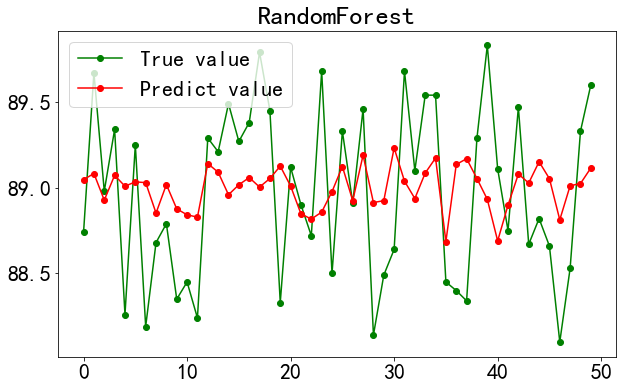

In [13]:
# 预测结果可视化
plt.style.use({'figure.figsize':(10,6)})
result = forest.predict(Xtest)
plt.figure()
plt.plot(np.arange(50), Ytest[:50], "go-", label="True value")
plt.plot(np.arange(50), result[:50], "ro-", label="Predict value")
plt.title(f"RandomForest")
plt.legend(loc="best")
plt.show()

In [14]:
rfr_score = forest.score(Xtest, Ytest)
print('rfr_score:',rfr_score)

from sklearn import metrics
rfr_rmse = metrics.mean_squared_error(Ytest,y_pred_rfr,squared=False)
print('rfr_rmse:',rfr_rmse)

rfr_score: 0.08910455564309927
rfr_rmse: 0.4824396271515799


## Lasso

In [15]:
from sklearn.linear_model import Lasso, LassoCV

In [17]:
lasso = LassoCV()
lasso.fit(Xtrain, Ytrain)   # 线性回归建模
print('系数矩阵:\n',lasso.coef_)
print('最佳的alpha：',lasso.alpha_)

系数矩阵:
 [-0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  1.2031813e-17
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
最佳的alpha： 0.09470445599349699


In [19]:
#特征重要性分析
# lassocv系数
coefs = pd.Series(lasso.coef_, index = features.columns)
coefs 

给料皮带G1_矿量反馈     -0.000000e+00
返料皮带F3_电流       -0.000000e+00
返料皮带F3_矿量        0.000000e+00
半自磨_功率1          0.000000e+00
半自磨_功率2          0.000000e+00
半自磨_进料端总高压      -0.000000e+00
半自磨_出料端总高压      -0.000000e+00
半自磨_给矿水流量反馈      0.000000e+00
半自磨_给矿水流量设定      0.000000e+00
半自磨_给矿水阀位        0.000000e+00
半自磨_排矿水流量        0.000000e+00
直线筛_冲筛水流量        0.000000e+00
一段泵池_液位         -0.000000e+00
一段泵池_补加水流量反馈     0.000000e+00
一段渣浆泵1_电流       -0.000000e+00
一段渣浆泵1_频率反馈      0.000000e+00
一段渣浆泵1_频率设定      0.000000e+00
一段渣浆泵1_矿浆流量反馈    0.000000e+00
一段渣浆泵1_矿浆流量设定    0.000000e+00
一段旋流器1_压力        1.203181e-17
球磨机_功率1          0.000000e+00
球磨机_功率2          0.000000e+00
球磨机_进料端总高压       0.000000e+00
球磨机_出料端总高压       0.000000e+00
球磨机_排矿水流量        0.000000e+00
球磨机_排矿水阀位        0.000000e+00
dtype: float64

Lasso模型挑选出 1 种特征，淘汰了其他的 25 种特征。


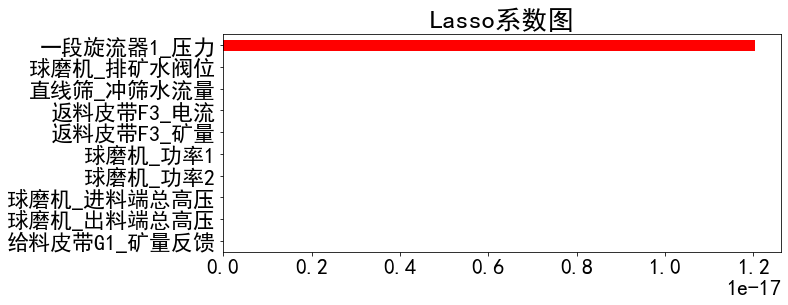

In [20]:
# 打印选定/淘汰的特征的数量
print("Lasso模型挑选出 " + str(sum(coefs != 0)) + " 种特征，淘汰了其他的 " +  \
      str(sum(coefs == 0)) + " 种特征。")
# 展示前5个和后5个
coefs = pd.concat([coefs.sort_values().head(5), coefs.sort_values().tail(5)])
plt.figure(figsize = (10, 4))
coefs.plot(kind = "barh", color = 'r')
plt.title("Lasso系数图")
plt.show() 

In [21]:
y_pred_lasso = lasso.predict(Xtest)
y_pred_lasso

array([88.9894702, 88.9894702, 88.9894702, 88.9894702, 88.9894702,
       88.9894702, 88.9894702, 88.9894702, 88.9894702, 88.9894702,
       88.9894702, 88.9894702, 88.9894702, 88.9894702, 88.9894702,
       88.9894702, 88.9894702, 88.9894702, 88.9894702, 88.9894702,
       88.9894702, 88.9894702, 88.9894702, 88.9894702, 88.9894702,
       88.9894702, 88.9894702, 88.9894702, 88.9894702, 88.9894702,
       88.9894702, 88.9894702, 88.9894702, 88.9894702, 88.9894702,
       88.9894702, 88.9894702, 88.9894702, 88.9894702, 88.9894702,
       88.9894702, 88.9894702, 88.9894702, 88.9894702, 88.9894702,
       88.9894702, 88.9894702, 88.9894702, 88.9894702, 88.9894702,
       88.9894702, 88.9894702, 88.9894702, 88.9894702, 88.9894702,
       88.9894702, 88.9894702, 88.9894702, 88.9894702, 88.9894702,
       88.9894702, 88.9894702, 88.9894702, 88.9894702, 88.9894702])

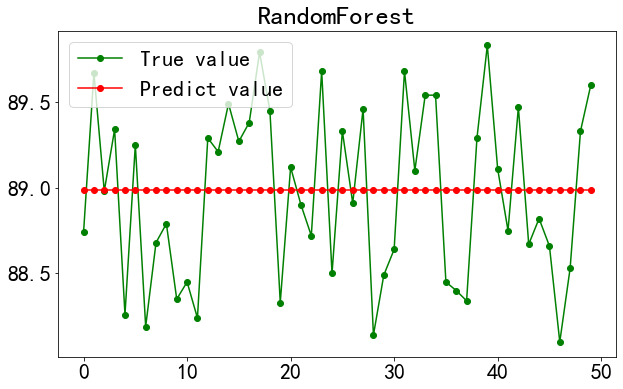

In [23]:
# 预测结果可视化
plt.style.use({'figure.figsize':(10,6)})
result = lasso.predict(Xtest)
plt.figure()
plt.plot(np.arange(50), Ytest[:50], "go-", label="True value")
plt.plot(np.arange(50), result[:50], "ro-", label="Predict value")
plt.title(f"RandomForest")
plt.legend(loc="best")
plt.show()

In [22]:
lasso_score = lasso.score(Xtest, Ytest)
print('lasso_score:',lasso_score)

from sklearn import metrics
lasso_rmse = metrics.mean_squared_error(Ytest,y_pred_rfr,squared=False)
print('lasso_rmse:',lasso_rmse)

lasso_score: -0.007653524653719934
lasso_rmse: 0.4824396271515799
